In [1]:
import scanpy as sc

In [2]:
import scvi

Global seed set to 0


In [3]:
scvi.settings.seed = 0

Global seed set to 0


In [4]:
adata=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/stromal_raw.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 391693 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type'

In [6]:
adata.X.expm1().sum(axis = 1)

/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scipy/sparse/_data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


matrix([[7.55158742e+185],
        [1.54605744e+025],
        [9.01999649e+006],
        ...,
        [6.56728315e+007],
        [2.42058720e+007],
        [1.80065703e+015]])

In [7]:
adata

AnnData object with n_obs × n_vars = 391693 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type'

In [8]:
adata.layers['raw_counts']=adata.X.copy()

In [9]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="raw_counts",
    batch_key="donor",
    span=1,
    subset=True,
)

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer="raw_counts", batch_key='donor', categorical_covariate_keys=['tech'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
model = scvi.model.SCVI(adata, n_hidden=120, n_layers=1, n_latent=10, gene_likelihood="zinb")

In [12]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [04:26<00:00, 13.05s/it, loss=852, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [04:26<00:00, 13.33s/it, loss=852, v_num=1]


In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [14]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)


In [15]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])


/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


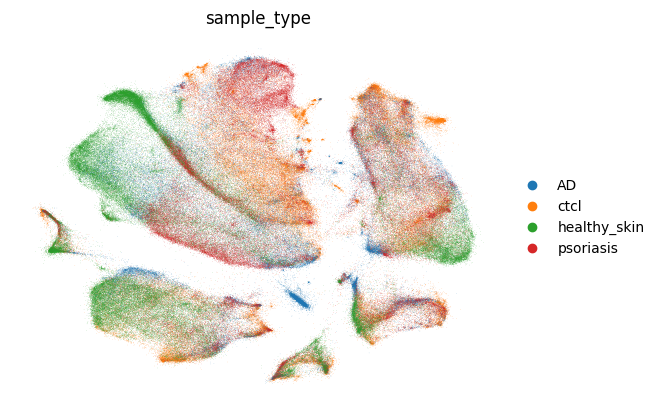

In [16]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["sample_type"],
    frameon=False,
    ncols=1,
)

In [17]:
model.save('/lustre/scratch126/cellgen/team298/ab72/CTCL/stromal_reproduce_default/stromal_def/', save_anndata= True )

In [18]:
adata.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/stromal_def_reproduce.h5ad')

In [19]:
adata2=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/stromal_raw.h5ad')

In [20]:
adata2.obsm=adata.obsm
adata2.obsp=adata.obsp
adata2.uns=adata.uns

In [17]:
#adata2.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/stromal_scvi_2k_4Dim_100hidd_sampletype_cov_24_6_from_raw.h5ad')

In [21]:
bc=adata2.obs.index.tolist()

In [22]:
annot=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects-new/all_samples_scvi_4kbydonor_6dim_100hidd_leiden_broad_ct_mastcell_corrected_celltypist.h5ad')

In [23]:
adata3=annot[bc, :].copy()

In [24]:
adata2.obs['cell_type']=adata3.obs['ctmajority_voting']

/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


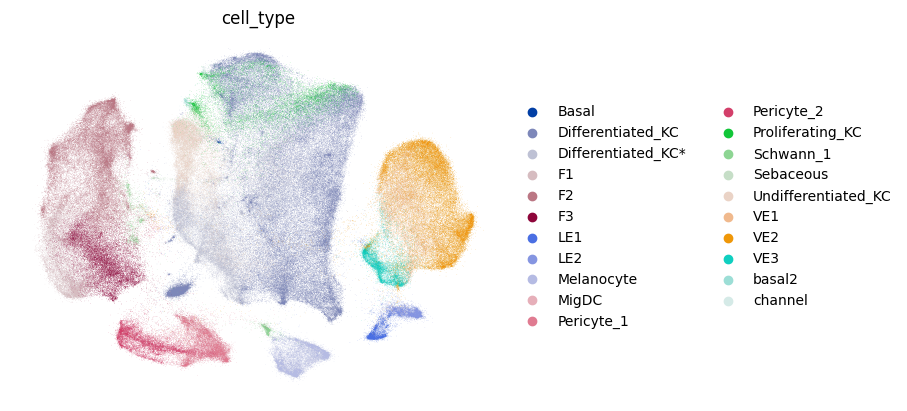

In [25]:
sc.pl.embedding(
    adata2,
    basis=SCVI_MDE_KEY,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)


In [26]:
adata2.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/stromal_scvi_2k_nhidden_120_default_celltypist_transfer_from_raw.h5ad')